
# Predicting Surface Temperature with CNN, LSTM, and Diffusion Models

This notebook is for the hyperparameter search of CNN and LSTM model, with 3 different task:

- **temp → temp**: predict the next sea-surface temperature map.
- **vel → vel**: predict the next horizontal velocity field with a zero-divergence penalty.
- **temp + vel → temp**: predict the next temperature conditioned on present temperature, present velocity, and the predicted next velocity.


In [5]:
import math
import random
import numpy as np
import xarray as xr
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

SEED = 42
DATA_PATH = '/kaggle/input/glorys-2014-2024/glorys_2014_2024 (1).nc'
PRED_HORIZON = 7
SEARCH_EPOCHS = 30     # epochs used ONLY for hyperparam selection
NUM_EPOCHS = 100       # (kept for compatibility; not used in this trimmed version)
BATCH_SIZE = 4
ADVECTION_DT = 1
DIFFUSIVITY = 1e-3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameter grids
TEMP_LRS = [1e-4, 3e-4, 1e-3]
VEL_LRS  = [1e-4, 3e-4, 1e-3]
COMB_LRS = [1e-4, 3e-4, 1e-3]

# Divergence weights for vel models
DIV_WEIGHTS = [0.0, 1e-3, 1e-2]

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

## 1. Load and prepare the GLORYS dataset

In [6]:
"""
STEP 1: Load GLORYS
"""
ds = xr.open_dataset(DATA_PATH)

# small subset for parameter search
ds = ds.isel(time=slice(0, 1095), latitude=slice(200, 220), longitude=slice(50, 70))
ds

<xarray.Dataset> Size: 11MB
Dimensions:    (time: 1095, depth: 1, latitude: 20, longitude: 20)
Coordinates:
  * depth      (depth) float32 4B 0.494
  * latitude   (latitude) float32 80B 24.67 24.75 24.83 ... 26.08 26.17 26.25
  * longitude  (longitude) float32 80B -97.83 -97.75 -97.67 ... -96.33 -96.25
  * time       (time) datetime64[ns] 9kB 2014-12-12 2014-12-13 ... 2017-12-10
Data variables:
    thetao     (time, depth, latitude, longitude) float64 4MB ...
    uo         (time, depth, latitude, longitude) float64 4MB ...
    vo         (time, depth, latitude, longitude) float64 4MB ...
Attributes:
    references:                http://www.mercator-ocean.fr
    title:                     daily mean fields from Global Ocean Physics An...
    source:                    MERCATOR GLORYS12V1
    institution:               MERCATOR OCEAN
    Conventions:               CF-1.4
    comment:                   CMEMS product
    history:                   2023/06/01 16:20:05 MERCATOR OCEAN Netcdf crea...
    copernicusmarine_version:  2.2.5

In [7]:
"""
STEP 2: build a common NaN mask, and normalize using only valid ocean points.
"""

sea_temp_raw = ds["thetao"].isel(depth=0).values.astype(np.float32)  # (time, lat, lon)
u_field_raw  = ds["uo"].isel(depth=0).values.astype(np.float32)
v_field_raw  = ds["vo"].isel(depth=0).values.astype(np.float32)

valid_3d = (
    np.isfinite(sea_temp_raw) &
    np.isfinite(u_field_raw) &
    np.isfinite(v_field_raw)
)

valid_2d = valid_3d.all(axis=0).astype(np.float32)

print("Total spatial pixels:", valid_2d.size)
print("Valid ocean pixels (common mask):", valid_2d.sum())

VALID_MASK = torch.tensor(valid_2d, dtype=torch.float32, device=DEVICE).unsqueeze(0).unsqueeze(0)

# Fill NaNs for model inputs
sea_temp = np.nan_to_num(sea_temp_raw, nan=0.0, posinf=0.0, neginf=0.0)
u_field  = np.nan_to_num(u_field_raw,  nan=0.0, posinf=0.0, neginf=0.0)
v_field  = np.nan_to_num(v_field_raw,  nan=0.0, posinf=0.0, neginf=0.0)

# Compute stats using ONLY valid ocean points (on this subset)
temp_mean = sea_temp_raw[valid_3d].mean()
temp_std  = sea_temp_raw[valid_3d].std() + 1e-6

vel_stack = np.stack([u_field_raw, v_field_raw], axis=0)  # (2, time, lat, lon)
vel_valid = np.isfinite(vel_stack) & np.broadcast_to(valid_3d, vel_stack.shape)
vel_mean  = vel_stack[vel_valid].mean()
vel_std   = vel_stack[vel_valid].std() + 1e-6

print("temp_mean, temp_std:", float(temp_mean), float(temp_std))
print("vel_mean, vel_std:", float(vel_mean), float(vel_std))

# Normalize
sea_temp_norm = (sea_temp - temp_mean) / temp_std
u_norm        = (u_field - vel_mean) / vel_std
v_norm        = (v_field - vel_mean) / vel_std

T, H, W = sea_temp_norm.shape
print("Normalized shapes:", sea_temp_norm.shape)

Total spatial pixels: 400
Valid ocean pixels (common mask): 278.0
temp_mean, temp_std: 25.703086853027344 3.398188875747681
vel_mean, vel_std: 0.020655041560530663 0.18353405757045746
Normalized shapes: (1095, 20, 20)


In [ ]:
'''
This code was used to check that the nan-mask is almost the same for temp and vel arrays for all t.
This allows us to use the same 2d nan mask.
'''

'''
import xarray as xr
import numpy as np

# Point this to your big file, e.g.:
# DATA_PATH = "glorys.nc"
ds = xr.open_dataset(DATA_PATH)

num_times = ds.dims["time"]
chunk_size = 8   # adjust if you want, this keeps memory small

diff_3d = 0                  # how many (t,lat,lon) points differ
temp_mask_2d = None          # will hold "valid at all times" for temp
vel_mask_2d = None           # same for velocity

for start in range(0, num_times, chunk_size):
    end = min(start + chunk_size, num_times)
    print(f"Processing time indices [{start}:{end})")

    # Load a small time chunk into memory
    temp_chunk = ds["thetao"].isel(depth=0, time=slice(start, end)).values  # (chunk, lat, lon)
    u_chunk    = ds["uo"].isel(depth=0, time=slice(start, end)).values
    v_chunk    = ds["vo"].isel(depth=0, time=slice(start, end)).values

    # Finite-value masks for this chunk
    temp_mask_chunk = np.isfinite(temp_chunk)
    vel_mask_chunk  = np.isfinite(u_chunk) & np.isfinite(v_chunk)

    # --- 3D comparison for this chunk ---
    diff_3d += np.count_nonzero(temp_mask_chunk != vel_mask_chunk)

    # --- Update 2D "valid for all times" masks ---
    # For this chunk, a cell is valid if it's valid at every time in the chunk
    temp_mask_2d_chunk = temp_mask_chunk.all(axis=0)   # (lat, lon)
    vel_mask_2d_chunk  = vel_mask_chunk.all(axis=0)

    if temp_mask_2d is None:
        # First chunk: initialize with this chunk's "all times" mask
        temp_mask_2d = temp_mask_2d_chunk
        vel_mask_2d  = vel_mask_2d_chunk
    else:
        # Later chunks: must also be valid in all previous chunks
        temp_mask_2d &= temp_mask_2d_chunk
        vel_mask_2d  &= vel_mask_2d_chunk

# After streaming through all time chunks:
same_3d = (diff_3d == 0)
same_2d = np.array_equal(temp_mask_2d, vel_mask_2d)
diff_2d = np.count_nonzero(temp_mask_2d != vel_mask_2d)

print("Do temp and vel masks match at every (t,lat,lon)?", same_3d)
print("Number of differing points in full 3D mask:", diff_3d)
print("Do temp and vel masks match as 2D spatial masks?", same_2d)
print("Number of differing pixels in 2D mask:", diff_2d)
print("Total valid ocean pixels (2D) in temp:", temp_mask_2d.sum())
print("Total valid ocean pixels (2D) in vel:", vel_mask_2d.sum())
'''

In [8]:
"""
STEP 3: Add seasonality encodings (sin/cos of day-of-year), and build input-output pairs
"""
# --- seasonality: day-of-year sin/cos ---
times = ds["time"].to_index()
day_of_year = times.dayofyear.values.astype(np.float32)  # 1..366

doy_norm = (day_of_year - 1) / 365.0
theta = 2 * np.pi * doy_norm
doy_sin = np.sin(theta).astype(np.float32)  # (T,)
doy_cos = np.cos(theta).astype(np.float32)  # (T,)

# broadcast to (T, H, W)
doy_sin_map = np.broadcast_to(doy_sin[:, None, None], (T, H, W)).astype(np.float32)
doy_cos_map = np.broadcast_to(doy_cos[:, None, None], (T, H, W)).astype(np.float32)

# We want:
# input at time t: [sin(doy(t)), cos(doy(t)), temp(t-1), temp(t)]  -> (4,H,W)
# target: temp(t+PRED_HORIZON) -> (1,H,W)
# with t = 1 .. T - PRED_HORIZON - 1

temp_in = torch.tensor(
    np.stack(
        [
            doy_sin_map[1:-PRED_HORIZON],              # seasonality sin at t
            doy_cos_map[1:-PRED_HORIZON],              # seasonality cos at t
            sea_temp_norm[0:-PRED_HORIZON-1],          # temp at (t-1)
            sea_temp_norm[1:-PRED_HORIZON],            # temp at t
        ],
        axis=1,
    ),
    dtype=torch.float32,
)

temp_out = torch.tensor(
    sea_temp_norm[PRED_HORIZON + 1:],
    dtype=torch.float32
).unsqueeze(1)  # (N,1,H,W)

# vel pairs: vel(t) -> vel(t+H)
vel_in = torch.tensor(
    np.stack([u_norm[:-PRED_HORIZON], v_norm[:-PRED_HORIZON]], axis=1),
    dtype=torch.float32
)
vel_out = torch.tensor(
    np.stack([u_norm[PRED_HORIZON:], v_norm[PRED_HORIZON:]], axis=1),
    dtype=torch.float32
)

pairs = temp_in.shape[0]
train_count = int(pairs * 0.7)
val_count   = int(pairs * 0.15)

train_idx = slice(0, train_count)
val_idx   = slice(train_count, train_count + val_count)
test_idx  = slice(train_count + val_count, pairs)

print("Prediction horizon:", PRED_HORIZON)
print("Temp pair shape:", temp_in.shape, temp_out.shape)   # (N,4,H,W), (N,1,H,W)
print("Vel  pair shape:", vel_in.shape, vel_out.shape)     # (N,2,H,W), (N,2,H,W)


Prediction horizon: 7
Temp pair shape: torch.Size([1087, 4, 20, 20]) torch.Size([1087, 1, 20, 20])
Vel  pair shape: torch.Size([1088, 2, 20, 20]) torch.Size([1088, 2, 20, 20])


### Data loaders

In [9]:

temp_train = TensorDataset(temp_in[train_idx], temp_out[train_idx])
temp_val   = TensorDataset(temp_in[val_idx],  temp_out[val_idx])
temp_test  = TensorDataset(temp_in[test_idx], temp_out[test_idx])

vel_train = TensorDataset(vel_in[train_idx], vel_out[train_idx])
vel_val   = TensorDataset(vel_in[val_idx],   vel_out[val_idx])
vel_test  = TensorDataset(vel_in[test_idx],  vel_out[test_idx])

loader_temp_train = DataLoader(temp_train, batch_size=BATCH_SIZE, shuffle=True)
loader_temp_val   = DataLoader(temp_val,   batch_size=BATCH_SIZE)
loader_temp_test  = DataLoader(temp_test,  batch_size=BATCH_SIZE)

loader_vel_train  = DataLoader(vel_train, batch_size=BATCH_SIZE, shuffle=True)
loader_vel_val    = DataLoader(vel_val,   batch_size=BATCH_SIZE)
loader_vel_test   = DataLoader(vel_test,  batch_size=BATCH_SIZE)

## 2. Utilities: RMSE, divergence penalty, and simple models

In [10]:
def temp_loss(pred, target):
    diff2 = (pred - target) ** 2
    diff2 = diff2 * VALID_MASK
    return diff2.sum() / VALID_MASK.sum()

def divergence(field):
    u = field[:, 0]
    v = field[:, 1]
    du_dx = u[:, :, 2:] - u[:, :, :-2]
    dv_dy = v[:, 2:, :] - v[:, :-2, :]
    du_dx = torch.nn.functional.pad(du_dx, (1, 1, 0, 0))
    dv_dy = torch.nn.functional.pad(dv_dy, (0, 0, 1, 1))
    return du_dx + dv_dy

def vel_loss(pred, target, div_weight):
    diff2 = (pred - target) ** 2
    diff2 = diff2 * VALID_MASK
    mse_term = diff2.sum() / VALID_MASK.sum()

    div_sq = (divergence(pred) ** 2) * VALID_MASK
    div_term = div_sq.sum() / VALID_MASK.sum()

    return mse_term + div_weight * div_term

def rmse(pred, target):
    diff2 = (pred - target) ** 2
    diff2 = diff2 * VALID_MASK
    pixels_per_sample = VALID_MASK.sum()
    total_points = pixels_per_sample * pred.size(0)
    return torch.sqrt(diff2.sum() / total_points).item()


In [21]:
#Model structures.

class SimpleCNN(nn.Module):
    def __init__(self, in_channels, out_channels, hidden=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, hidden, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden, hidden, 3, padding=1),
            nn.ReLU(),
            #Uncomment when training 4 layers.
            nn.Conv2d(hidden, hidden, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden, out_channels, 3, padding=1)
        )
    def forward(self, x):
        return self.net(x)

class SimpleLSTM(nn.Module):
    def __init__(self, in_channels, out_channels, hidden=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=in_channels,
            hidden_size=hidden,
            num_layers=num_layers,
            batch_first=True,
        )
        self.head = nn.Linear(hidden, out_channels)

    def forward(self, x):
        b, c, h, w = x.shape
        seq = x.permute(0, 2, 3, 1).reshape(b, h * w, c).contiguous()
        out, _ = self.lstm(seq)
        out = self.head(out)
        out = out.reshape(b, h, w, -1).permute(0, 3, 1, 2)
        return out


In [30]:
#Setting training parameters. Uncomment LSTM when training them.

# take 2 temp snapshots and output 1 temp snapshot prediction PRED_HORIZON days in future
#un comment codes you need to train
temp_candidates = [
    ('cnn16', lambda: SimpleCNN(4, 1, hidden=16)),
    ('cnn32', lambda: SimpleCNN(4, 1, hidden=32)),
    ('cnn64', lambda: SimpleCNN(4, 1, hidden=64)),
    # ('lstm32_1L', lambda: SimpleLSTM(4, 1, hidden=32, num_layers=1)),
    # ('lstm32_2L', lambda: SimpleLSTM(4, 1, hidden=32, num_layers=2)),
    # ('lstm64_1L', lambda: SimpleLSTM(4, 1, hidden=64, num_layers=1)),
    # ('lstm64_2L', lambda: SimpleLSTM(4, 1, hidden=64, num_layers=2)),
    # ('lstm128_1L', lambda: SimpleLSTM(4, 1, hidden=128, num_layers=1)),
    # ('lstm128_2L', lambda: SimpleLSTM(4, 1, hidden=128, num_layers=2)),
]
# take 1 vel snapshot and output 1 vel snapshot prediction PRED_HORIZON days in future
vel_candidates = [
    ('cnn16', lambda: SimpleCNN(2, 2, hidden=16)),
    ('cnn32', lambda: SimpleCNN(2, 2, hidden=32)),
    ('cnn64', lambda: SimpleCNN(2, 2, hidden=64)),
    # ('lstm32_1L', lambda: SimpleLSTM(2, 2, hidden=32, num_layers=1)),
    # ('lstm32_2L', lambda: SimpleLSTM(2, 2, hidden=32, num_layers=2)),
    # ('lstm64_1L', lambda: SimpleLSTM(2, 2, hidden=64, num_layers=1)),
    # ('lstm64_2L', lambda: SimpleLSTM(2, 2, hidden=64, num_layers=2)),
    # ('lstm128_1L', lambda: SimpleLSTM(2, 2, hidden=128, num_layers=1)),
    # ('lstm128_2L', lambda: SimpleLSTM(2, 2, hidden=128, num_layers=2)),
]
# take 2 temp snapshots, 1 vel snapshot, and 1 predicted vel snapshot and output 1 temp snapshot prediction PRED_HORIZON days in future
tvt_candidates = [
    ('cnn24', lambda: SimpleCNN(6, 1, hidden=24)),
    ('cnn48', lambda: SimpleCNN(6, 1, hidden=48)),
    ('cnn96', lambda: SimpleCNN(6, 1, hidden=96)),
    # ('lstm96_1L', lambda: SimpleLSTM(6, 1, hidden=96,num_layers=1)),
    # ('lstm96_2L', lambda: SimpleLSTM(6, 1, hidden=96,num_layers=2)),
    # ('lstm48_1L', lambda: SimpleLSTM(6, 1, hidden=48,num_layers=1)),
    # ('lstm96_2L', lambda: SimpleLSTM(6, 1, hidden=96,num_layers=2)),
]


### Training helpers

In [13]:
def train_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0.0
    for xin, y in loader:
        xin = xin.to(DEVICE)
        y   = y.to(DEVICE)

        optimizer.zero_grad()
        pred = model(xin)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

def train_epoch_vel(model, loader, optimizer, div_weight: float):
    model.train()
    total_loss = 0.0
    for xin, y in loader:
        xin = xin.to(DEVICE)
        y   = y.to(DEVICE)

        optimizer.zero_grad()
        preds = model(xin)
        loss = vel_loss(preds, y, div_weight)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def evaluate_model_rmse(model, loader):
    model.eval()
    rmses = []
    for xin, y in loader:
        xin = xin.to(DEVICE)
        y   = y.to(DEVICE)
        preds = model(xin)
        rmses.append(rmse(preds, y))
    return sum(rmses) / len(rmses)


## 3. Temp → Temp models

In [22]:
val_scores_temp = {}
best_temp_name = None
best_temp_lr = None
best_temp_rmse = float('inf')

for name, build_model in temp_candidates:
    for lr in TEMP_LRS:
        model = build_model().to(DEVICE)
        opt = torch.optim.Adam(model.parameters(), lr=lr)

        for _ in range(SEARCH_EPOCHS):
            train_epoch(model, loader_temp_train, opt, temp_loss)

        val_rmse = evaluate_model_rmse(model, loader_temp_val)
        val_scores_temp[(name, lr)] = val_rmse

        print(f"Temp {name}, lr={lr:g} VAL RMSE: {val_rmse:.4f}")

        if val_rmse < best_temp_rmse:
            best_temp_rmse = val_rmse
            best_temp_name = name
            best_temp_lr   = lr

print("Best TEMP model:",
      best_temp_name,
      "lr=", best_temp_lr,
      "VAL RMSE=", best_temp_rmse)

Temp cnn16, lr=0.0001 VAL RMSE: 0.2573
Temp cnn16, lr=0.0003 VAL RMSE: 0.2924
Temp cnn16, lr=0.001 VAL RMSE: 0.2763
Temp cnn32, lr=0.0001 VAL RMSE: 0.2476
Temp cnn32, lr=0.0003 VAL RMSE: 0.3231
Temp cnn32, lr=0.001 VAL RMSE: 0.3140
Temp cnn64, lr=0.0001 VAL RMSE: 0.3046
Temp cnn64, lr=0.0003 VAL RMSE: 0.2960
Temp cnn64, lr=0.001 VAL RMSE: 0.3149
Best TEMP model: cnn32 lr= 0.0001 VAL RMSE= 0.2475705755556502


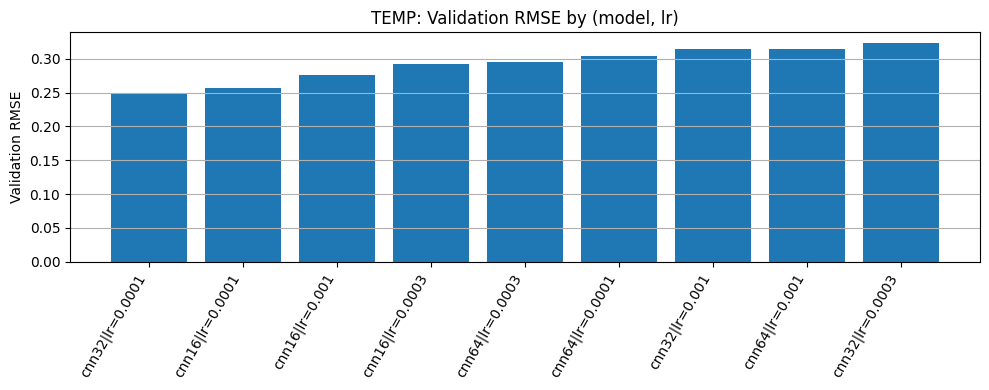

In [23]:
def plot_val_scores_bar(val_scores, title="Validation RMSE (all combos)", top_k=None):
    # val_scores: dict {(name, lr): rmse}
    items = [ (f"{name}|lr={lr:g}", rmse) for (name, lr), rmse in val_scores.items() ]
    items.sort(key=lambda x: x[1])  # sort by rmse ascending

    if top_k is not None:
        items = items[:top_k]

    labels = [k for k, _ in items]
    rmses  = [v for _, v in items]

    plt.figure(figsize=(max(10, 0.45 * len(items)), 4))
    plt.bar(np.arange(len(items)), rmses)
    plt.xticks(np.arange(len(items)), labels, rotation=60, ha="right")
    plt.ylabel("Validation RMSE")
    plt.title(title)
    plt.grid(True, axis="y")
    plt.tight_layout()
    plt.show()

plot_val_scores_bar(val_scores_temp, title="TEMP: Validation RMSE by (model, lr)", top_k=None)

## 4. Vel → Vel models (divergence penalty)

In [24]:
val_scores_vel_non_diff = {}

best_vel_non_diff_name = None
best_vel_non_diff_lr   = None
best_vel_non_diff_div  = None
best_vel_non_diff_rmse = float('inf')

# -------- non-diffusion vel: search over model × LR × div_weight --------
for name, build_model in vel_candidates:
    for lr in VEL_LRS:
        for div_w in DIV_WEIGHTS:
            model = build_model().to(DEVICE)
            opt = torch.optim.Adam(model.parameters(), lr=lr)

            # short search training
            for _ in range(SEARCH_EPOCHS):
                train_epoch_vel(model, loader_vel_train, opt, div_w)

            # validation RMSE
            val_rmse = evaluate_model_rmse(model, loader_vel_val)
            # val_rmse = evaluate_model(model, loader_vel_val, diffusion=False, out_channels=2)

            val_scores_vel_non_diff[(name, lr, div_w)] = val_rmse
            print(f"Vel non-diff {name}, lr={lr:g}, div_w={div_w:g}, VAL RMSE: {val_rmse:.4f}")

            if val_rmse < best_vel_non_diff_rmse:
                best_vel_non_diff_rmse = val_rmse
                best_vel_non_diff_name = name
                best_vel_non_diff_lr   = lr
                best_vel_non_diff_div  = div_w

print(
    "Best vel non-diff:",
    best_vel_non_diff_name,
    "lr=", best_vel_non_diff_lr,
    "div_w=", best_vel_non_diff_div,
    "VAL RMSE=", best_vel_non_diff_rmse,
)

Vel non-diff cnn16, lr=0.0001, div_w=0, VAL RMSE: 1.1585
Vel non-diff cnn16, lr=0.0001, div_w=0.001, VAL RMSE: 1.1579
Vel non-diff cnn16, lr=0.0001, div_w=0.01, VAL RMSE: 1.1127
Vel non-diff cnn16, lr=0.0003, div_w=0, VAL RMSE: 1.1568
Vel non-diff cnn16, lr=0.0003, div_w=0.001, VAL RMSE: 1.1372
Vel non-diff cnn16, lr=0.0003, div_w=0.01, VAL RMSE: 1.1455
Vel non-diff cnn16, lr=0.001, div_w=0, VAL RMSE: 1.1890
Vel non-diff cnn16, lr=0.001, div_w=0.001, VAL RMSE: 1.1572
Vel non-diff cnn16, lr=0.001, div_w=0.01, VAL RMSE: 1.1906
Vel non-diff cnn32, lr=0.0001, div_w=0, VAL RMSE: 1.1452
Vel non-diff cnn32, lr=0.0001, div_w=0.001, VAL RMSE: 1.1481
Vel non-diff cnn32, lr=0.0001, div_w=0.01, VAL RMSE: 1.1165
Vel non-diff cnn32, lr=0.0003, div_w=0, VAL RMSE: 1.1370
Vel non-diff cnn32, lr=0.0003, div_w=0.001, VAL RMSE: 1.1748
Vel non-diff cnn32, lr=0.0003, div_w=0.01, VAL RMSE: 1.1578
Vel non-diff cnn32, lr=0.001, div_w=0, VAL RMSE: 1.2117
Vel non-diff cnn32, lr=0.001, div_w=0.001, VAL RMSE: 1.22

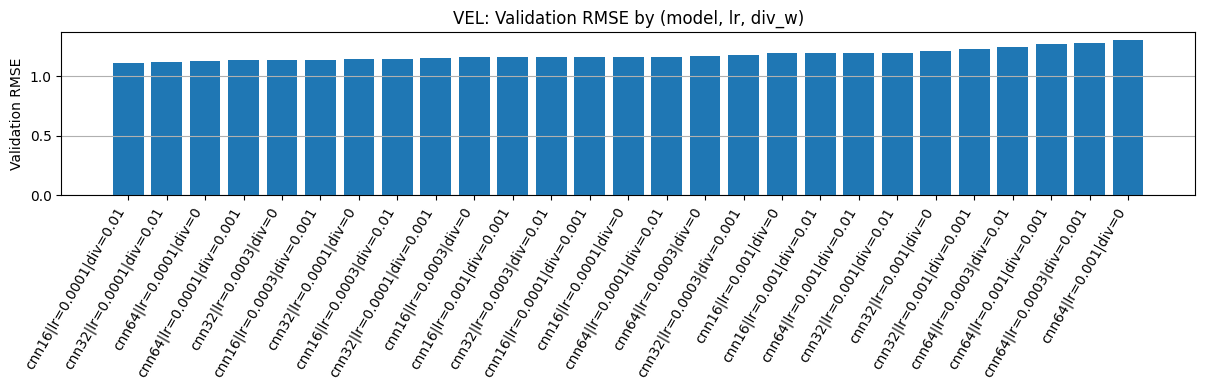

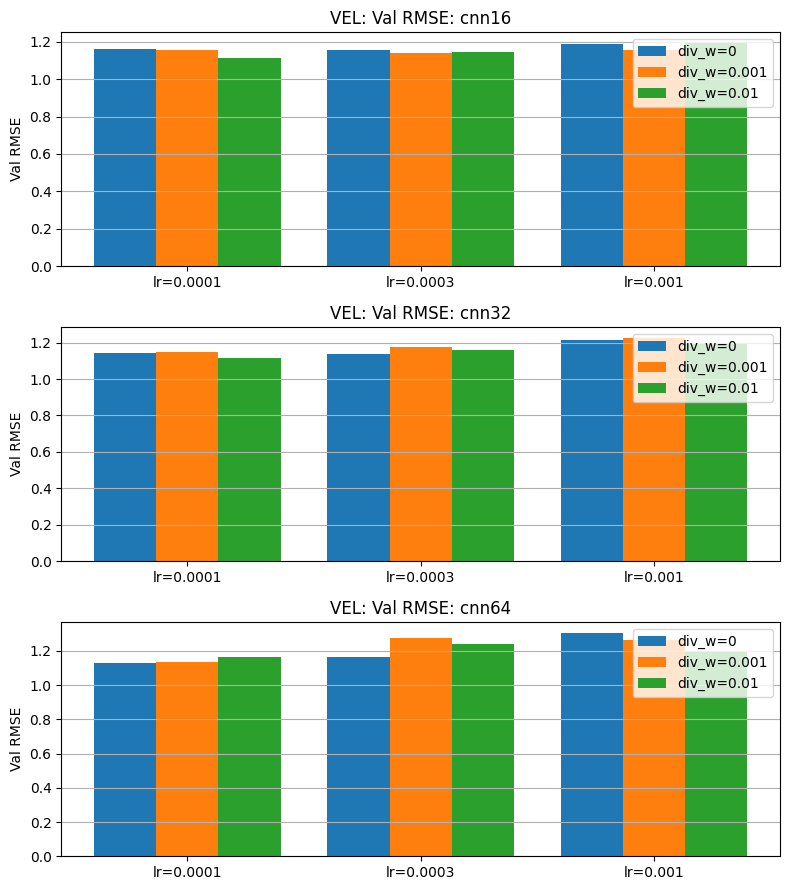

[VEL] Best combo = model=cnn16, lr=0.0001, div_w=0.01, val_rmse=1.1127


In [25]:

# -----------------------
# Plot A: all combos sorted bar chart
# -----------------------
def plot_vel_scores_bar_all(val_scores, title="VEL: Validation RMSE by (model, lr, div_w)", top_k=None):
    items = [ (f"{name}|lr={lr:g}|div={div_w:g}", rmse)
              for (name, lr, div_w), rmse in val_scores.items() ]
    items.sort(key=lambda x: x[1])

    if top_k is not None:
        items = items[:top_k]

    labels = [k for k, _ in items]
    rmses  = [v for _, v in items]

    plt.figure(figsize=(max(10, 0.45 * len(items)), 4))
    plt.bar(np.arange(len(items)), rmses)
    plt.xticks(np.arange(len(items)), labels, rotation=60, ha="right")
    plt.ylabel("Validation RMSE")
    plt.title(title)
    plt.grid(True, axis="y")
    plt.tight_layout()
    plt.show()

plot_vel_scores_bar_all(val_scores_vel_non_diff, top_k=None)
# plot_vel_scores_bar_all(val_scores_vel_non_diff, top_k=15)

# -----------------------
# Plot B: grouped by model (per-model subplots), x=lr, bars=div_w
# -----------------------
def plot_vel_scores_grouped(val_scores, lr_list, div_list, title_prefix="VEL grouped"):
    model_names = sorted({name for (name, lr, div_w) in val_scores.keys()})
    n_models = len(model_names)

    fig, axes = plt.subplots(n_models, 1, figsize=(8, 3 * n_models), squeeze=False)
    axes = axes[:, 0]

    width = 0.8 / max(len(div_list), 1)
    x = np.arange(len(lr_list))

    for ax, m in zip(axes, model_names):
        for i, div_w in enumerate(div_list):
            rmses = [val_scores.get((m, lr, div_w), np.nan) for lr in lr_list]
            offset = (i - (len(div_list) - 1) / 2) * width
            ax.bar(x + offset, rmses, width=width, label=f"div_w={div_w:g}")

        ax.set_xticks(x)
        ax.set_xticklabels([f"lr={lr:g}" for lr in lr_list])
        ax.set_ylabel("Val RMSE")
        ax.set_title(f"{title_prefix}: {m}")
        ax.grid(True, axis="y")
        ax.legend()

    plt.tight_layout()
    plt.show()

plot_vel_scores_grouped(val_scores_vel_non_diff, VEL_LRS, DIV_WEIGHTS, title_prefix="VEL: Val RMSE")

# -----------------------
best_key = min(val_scores_vel_non_diff, key=val_scores_vel_non_diff.get)
print(f"[VEL] Best combo = model={best_key[0]}, lr={best_key[1]:g}, div_w={best_key[2]:g}, val_rmse={val_scores_vel_non_diff[best_key]:.4f}")


## 5.temp + vel → temp

Temp+Vel input shape: torch.Size([1087, 6, 20, 20])
Temp target shape: torch.Size([1087, 1, 20, 20])
[TVT] cnn24, lr=0.0001  VAL RMSE: 0.2446
[TVT] cnn24, lr=0.0003  VAL RMSE: 0.2476
[TVT] cnn24, lr=0.001  VAL RMSE: 0.2527
[TVT] cnn48, lr=0.0001  VAL RMSE: 0.2295
[TVT] cnn48, lr=0.0003  VAL RMSE: 0.3003
[TVT] cnn48, lr=0.001  VAL RMSE: 0.4328
[TVT] cnn96, lr=0.0001  VAL RMSE: 0.3181
[TVT] cnn96, lr=0.0003  VAL RMSE: 0.4157
[TVT] cnn96, lr=0.001  VAL RMSE: 0.3581

Best TVT model: cnn48 lr= 0.0001 VAL RMSE= 0.2295422112432922


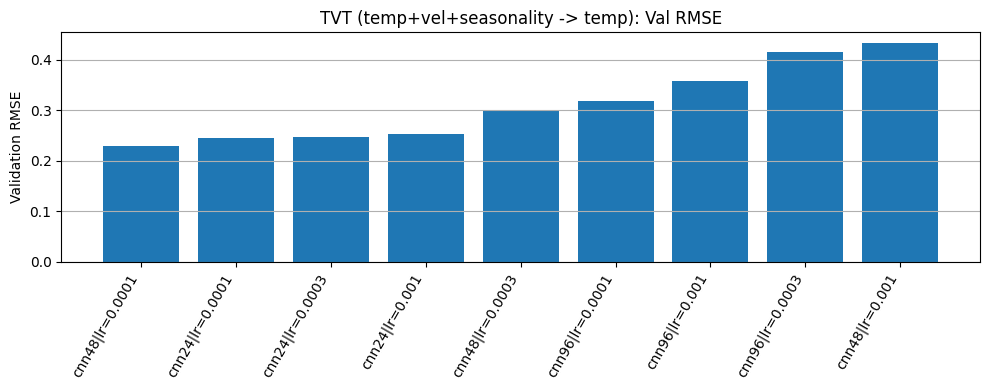

[TVT] Best combo test RMSE: 0.1482


In [32]:
"""
STEP X: Build temp+vel(+seasonality) -> temp dataset (TVT: temp+vel -> temp)
Inputs (6 ch): [sin(doy(t)), cos(doy(t)), temp(t-1), temp(t), u(t), v(t)]
Target (1 ch): temp(t + PRED_HORIZON)
"""

# ------------- build combined input -------------
temp_vel_in = torch.tensor(
    np.stack(
        [
            doy_sin_map[1:-PRED_HORIZON],     # sin(doy(t))
            doy_cos_map[1:-PRED_HORIZON],     # cos(doy(t))
            sea_temp_norm[0:-PRED_HORIZON-1], # temp(t-1)
            sea_temp_norm[1:-PRED_HORIZON],   # temp(t)
            u_norm[1:-PRED_HORIZON],          # u(t)
            v_norm[1:-PRED_HORIZON],          # v(t)
        ],
        axis=1
    ),
    dtype=torch.float32
)

temp_vel_out = temp_out

print("Temp+Vel input shape:", temp_vel_in.shape)   # (N,6,H,W)
print("Temp target shape:", temp_vel_out.shape)     # (N,1,H,W)

# ------------- split and loaders -------------
temp_vel_train = TensorDataset(temp_vel_in[train_idx], temp_vel_out[train_idx])
temp_vel_val   = TensorDataset(temp_vel_in[val_idx],   temp_vel_out[val_idx])
temp_vel_test  = TensorDataset(temp_vel_in[test_idx],  temp_vel_out[test_idx])

loader_tvt_train = DataLoader(temp_vel_train, batch_size=BATCH_SIZE, shuffle=True)
loader_tvt_val   = DataLoader(temp_vel_val,   batch_size=BATCH_SIZE)
loader_tvt_test  = DataLoader(temp_vel_test,  batch_size=BATCH_SIZE)


# ------------- search over (model, lr) -------------
val_scores_tvt = {}
best_tvt_name = None
best_tvt_lr   = None
best_tvt_rmse = float("inf")

for name, build_model in tvt_candidates:
    for lr in COMB_LRS:
        model = build_model().to(DEVICE)
        opt = torch.optim.Adam(model.parameters(), lr=lr)

        for _ in range(SEARCH_EPOCHS):
            train_epoch(model, loader_tvt_train, opt, temp_loss)

        val_rmse = evaluate_model_rmse(model, loader_tvt_val)
        val_scores_tvt[(name, lr)] = val_rmse
        print(f"[TVT] {name}, lr={lr:g}  VAL RMSE: {val_rmse:.4f}")

        if val_rmse < best_tvt_rmse:
            best_tvt_rmse = val_rmse
            best_tvt_name = name
            best_tvt_lr   = lr

print("\nBest TVT model:",
      best_tvt_name,
      "lr=", best_tvt_lr,
      "VAL RMSE=", best_tvt_rmse)

# ------------- bar chart for all combos -------------
def plot_val_scores_bar_tvt(val_scores, title="TVT: Validation RMSE by (model, lr)", top_k=None):
    items = [ (f"{name}|lr={lr:g}", rmse) for (name, lr), rmse in val_scores.items() ]
    items.sort(key=lambda x: x[1])  # rmse ascending
    if top_k is not None:
        items = items[:top_k]

    labels = [k for k, _ in items]
    rmses  = [v for _, v in items]

    plt.figure(figsize=(max(10, 0.45 * len(items)), 4))
    plt.bar(np.arange(len(items)), rmses)
    plt.xticks(np.arange(len(items)), labels, rotation=60, ha="right")
    plt.ylabel("Validation RMSE")
    plt.title(title)
    plt.grid(True, axis="y")
    plt.tight_layout()
    plt.show()

plot_val_scores_bar_tvt(val_scores_tvt, title="TVT (temp+vel+seasonality -> temp): Val RMSE", top_k=None)

best_tvt_model = dict(tvt_candidates)[best_tvt_name]().to(DEVICE)
opt = torch.optim.Adam(best_tvt_model.parameters(), lr=best_tvt_lr)
for _ in range(SEARCH_EPOCHS):
    train_epoch(best_tvt_model, loader_tvt_train, opt, temp_loss)

test_rmse = evaluate_model_rmse(best_tvt_model, loader_tvt_test)
print(f"[TVT] Best combo test RMSE: {test_rmse:.4f}")
